In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cluster import distance_values
from Bio import SeqIO
from Bio import Phylo
from showHOR import show_hor, show_hors, show_hor_tree
from featureUtils import BED_file_to_features, feature_to_seq, remove_overlapping_features
from parallel_distance import build_seqs_distance_matrix_by_chunks, FileSystemChunkStore
from hor import hor_tree_as_phyloxml_phylogeny
from hor_tree import phylogeny_to_hor_tree, find_inversion_hors
from Bio.Phylo.PhyloXML import Phyloxml
from Bio.Phylo import PhyloXMLIO
from clustering_to_phylogeny import clustering_to_phylogeny
from mixed_direction_hors import find_inversion_loops



In [2]:
references = {seq.id : seq for seq in SeqIO.parse("./data/chr4_human/HSA.chr4.fasta", "fasta")}

In [3]:
monomers_as_features = BED_file_to_features("./data/chr4_human/final_decomposition.bed")

In [4]:
# monomers_as_features = remove_overlapping_features(
#     features=monomers_as_features,
#     expected_feature_size=171,
#     max_allowed_overlap_fraction=0.25
# )

In [5]:
# sample monomers for testing purposes (comment out for complete analysis)

# sample_size = 60
# num_samples = 5

# sample_page = len(monomers_as_features) // num_samples
# sample_offset = (sample_page - sample_size) // 2

# def slice_seq(seq, position, length):
#     return seq[position : position + length]

# monomers_as_features = [
#     monomer
#     for sample_index in range(num_samples)
#     for monomer in slice_seq(monomers_as_features, sample_index * sample_page + sample_offset, sample_size)
# ]

In [6]:
monomers_as_seqs = [feature_to_seq(feature, references) for feature in monomers_as_features]

In [7]:
import math


math.ceil(len(monomers_as_seqs) / 24)

31

In [8]:
len(monomers_as_seqs) / 32

23.21875

In [9]:
monomer_dists = build_seqs_distance_matrix_by_chunks(monomers_as_seqs, num_chunks=32, chunk_store=FileSystemChunkStore("data/chr4_human/submatrices_32/piece_{row}_{col}"))

# of chunks for computing distance matrix: 32
Chunk size: 24
Num processes: 481
Blocks: ['([0:1](24,24))', '([0:2](24,24))', '([1:2](24,24))', '([0:3](24,24))', '([1:3](24,24))', '([2:3](24,24))', '([0:4](24,24))', '([1:4](24,24))', '([2:4](24,24))', '([3:4](24,24))', '([0:5](24,24))', '([1:5](24,24))', '([2:5](24,24))', '([3:5](24,24))', '([4:5](24,24))', '([0:6](24,24))', '([1:6](24,24))', '([2:6](24,24))', '([3:6](24,24))', '([4:6](24,24))', '([5:6](24,24))', '([0:7](24,24))', '([1:7](24,24))', '([2:7](24,24))', '([3:7](24,24))', '([4:7](24,24))', '([5:7](24,24))', '([6:7](24,24))', '([0:8](24,24))', '([1:8](24,24))', '([2:8](24,24))', '([3:8](24,24))', '([4:8](24,24))', '([5:8](24,24))', '([6:8](24,24))', '([7:8](24,24))', '([0:9](24,24))', '([1:9](24,24))', '([2:9](24,24))', '([3:9](24,24))', '([4:9](24,24))', '([5:9](24,24))', '([6:9](24,24))', '([7:9](24,24))', '([8:9](24,24))', '([0:10](24,24))', '([1:10](24,24))', '([2:10](24,24))', '([3:10](24,24))', '([4:10](24,24))', '([5:1

In [10]:
with open('data/fileschr4chimp/distances.npy', 'wb') as f:
    np.save(f, monomer_dists)

(array([ 5429.,  3176.,  1648.,   619.,   399.,   200.,   182.,   145.,
           89.,    57.,    57.,   133.,   210.,   331.,   196.,   114.,
          127.,    95.,   134.,   449.,  1580.,  1907.,  2050.,  1992.,
          738.,   609.,  1818.,  5861.,  6319.,  5270.,  6093.,  3455.,
         3869.,  2629.,  7518.,  3979.,  6034.,  4438.,  5332.,  9257.,
         8948.,  9017.,  9450., 12696., 11969., 10268., 15940., 13937.,
        15557., 13023.,  7774.,  6570.,  3541.,  3970.,  3671.,  2739.,
         1353.,   804.,   337.,   165.,   103.,    96.,   217.,   122.,
           72.,   124.,   142.,   165.,   233.,   134.,   111.,   170.,
          129.,   182.,   101.,    81.,   265.,   191.,   153.,   242.,
          255.,   679.,   996.,  1606.,  2294.,  2958.,  2955.,  3107.,
         3347.,  2636.,  2458.,  1339.,   752.,   387.,   237.,   139.,
           89.,    52.,    67.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
        13., 14., 15., 16., 1

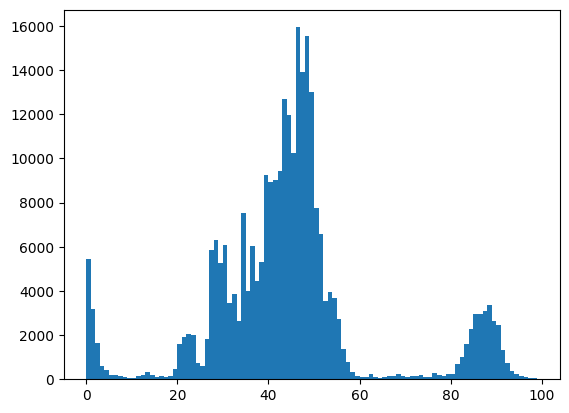

In [11]:
dist_values = distance_values(monomer_dists)
plt.hist(dist_values, bins=int(max(dist_values)))

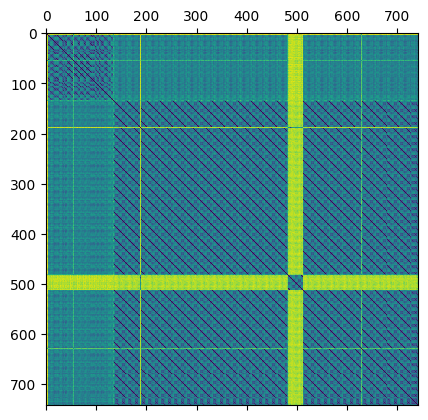

In [12]:
plt.matshow(monomer_dists)

In [13]:
clustering_res = clustering_to_phylogeny(
    dist_matrix=monomer_dists,
    items_as_seq_features=monomers_as_features,
    seq_references=references
)
phylogeny = clustering_res.phylogeny

In [14]:
phyloXml = Phyloxml(phylogenies=[phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, './data/fileschr4chimp/monomer_phylogeny.xml')

1

In [15]:
hor_tree_root = phylogeny_to_hor_tree(phylogeny, min_loops=5, allow_hor_overlap=False)

In [16]:
inversion_loops = find_inversion_loops(seq_features=monomers_as_features, min_loops=5)
[str(loop_inSeq) for loop_inSeq in inversion_loops]

[]

In [18]:
inversion_hor_tree = find_inversion_hors(seq_features=monomers_as_features, min_loops=5)
#show_hors(hors_in_seq=inversion_hor_tree.sub_hors, reference_seq=references['chr4_hap2_hsa5:64806450-67061718'])

In [19]:
hor_phylogeny = hor_tree_as_phyloxml_phylogeny(hor_tree_root)

/Users/miguel/git/dna-repeat-discovery/env/lib/python3.11/site-packages/Bio/Phylo/PhyloXML.py:985: PhyloXMLWarning: String monomer_clade_seq doesn't match the given regexp
  _check_str(ref, self.re_ref.match)


In [20]:
phyloXml = Phyloxml(phylogenies=[hor_phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, './data/fileschr4chimp/HORs.xml')

1

In [21]:
phyloXml = Phyloxml(phylogenies=[phylogeny, hor_phylogeny], attributes=None)
PhyloXMLIO.write(phyloXml, './data/fileschr4chimp/monomer_phylogeny_and_HORs.xml')

2

Subtree: []
None


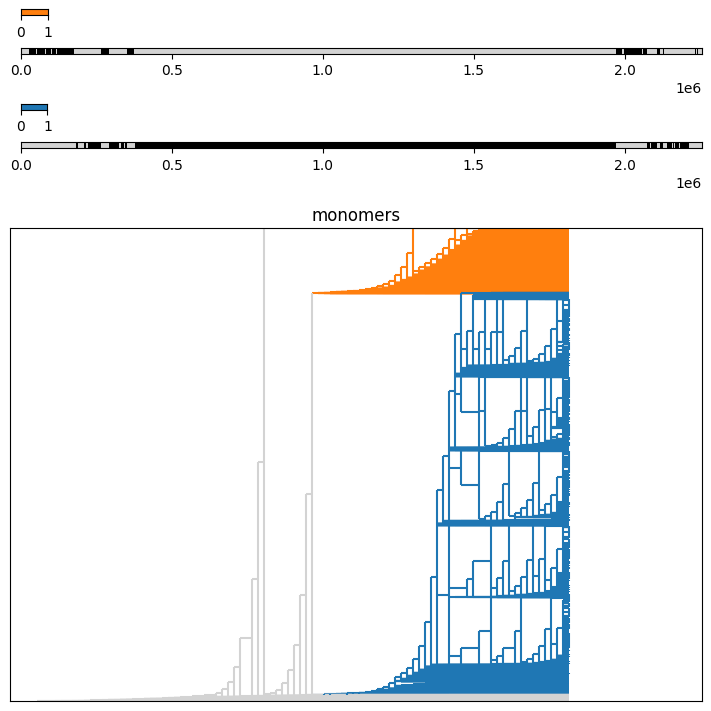

Subtree: [2]
None


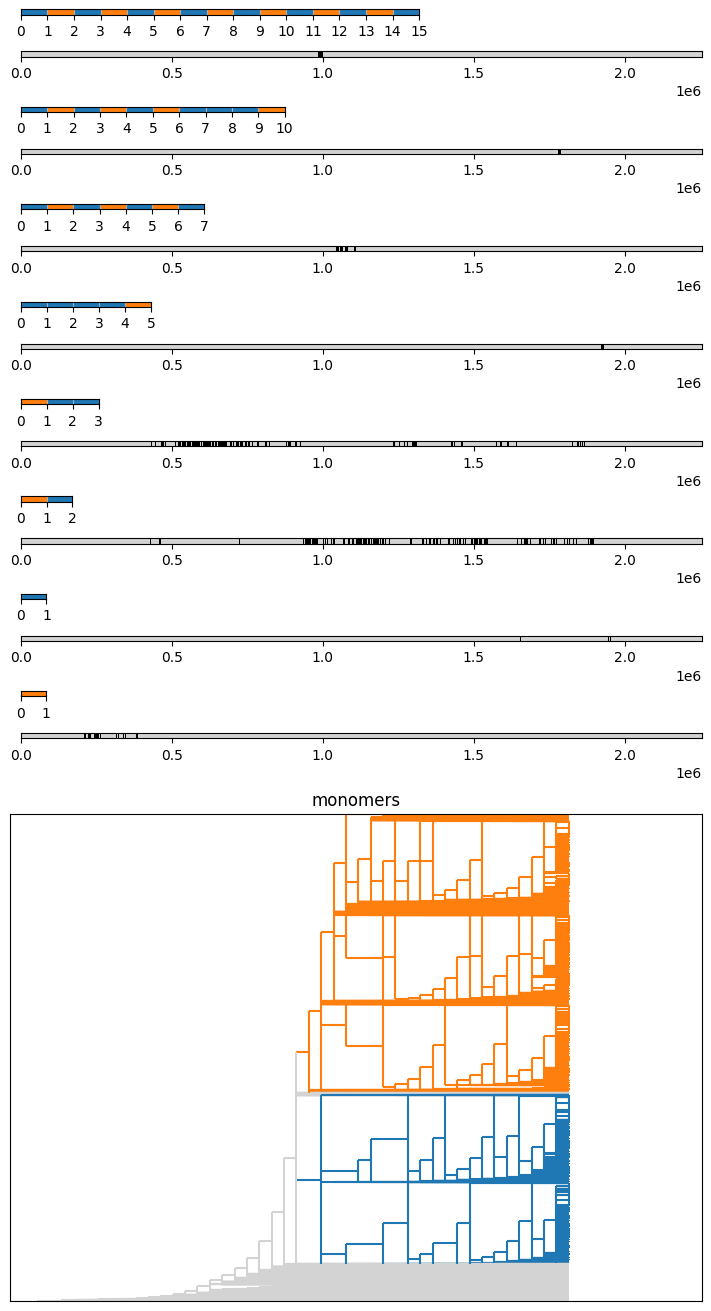

Subtree: [2, 1]
None


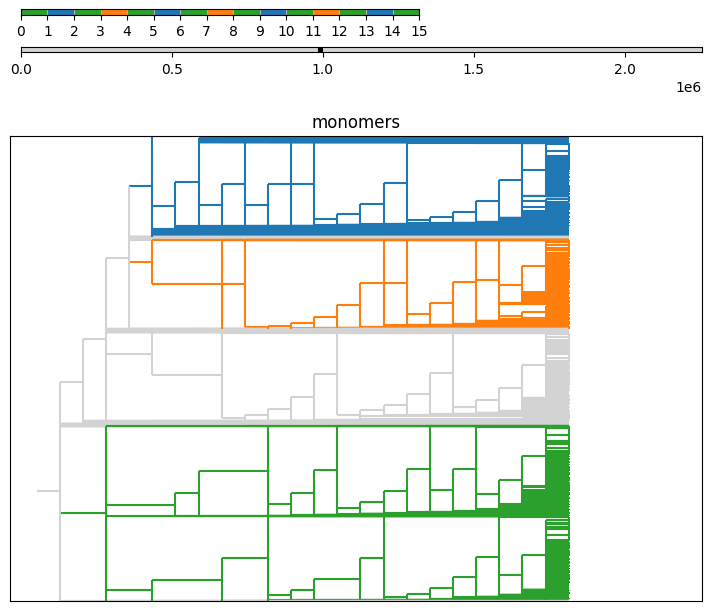

Subtree: [2, 1, 1]
None


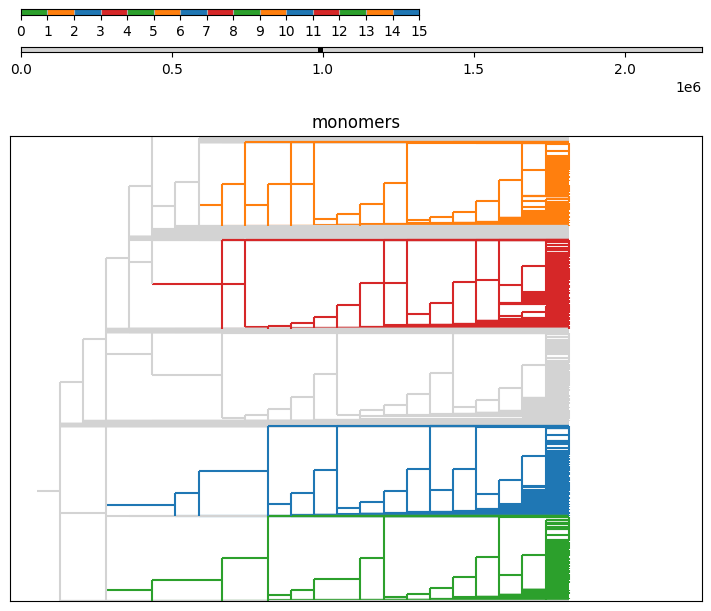

Subtree: [2, 2]
None


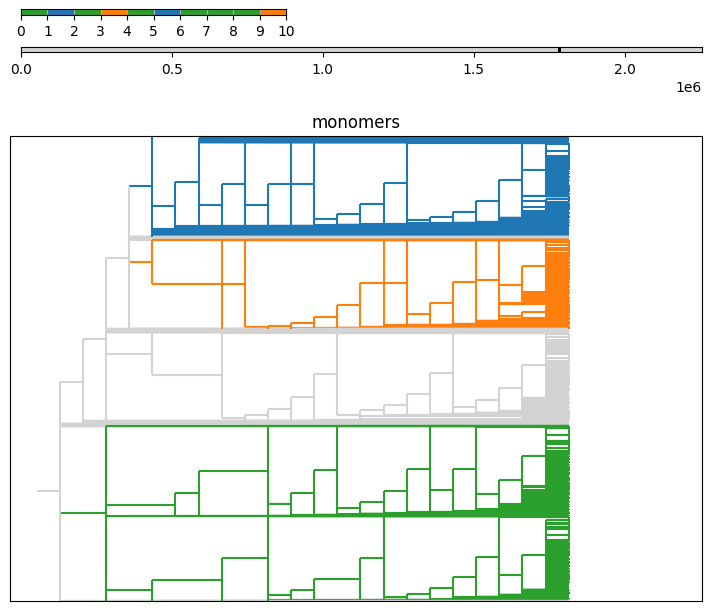

Subtree: [2, 2, 1]
None


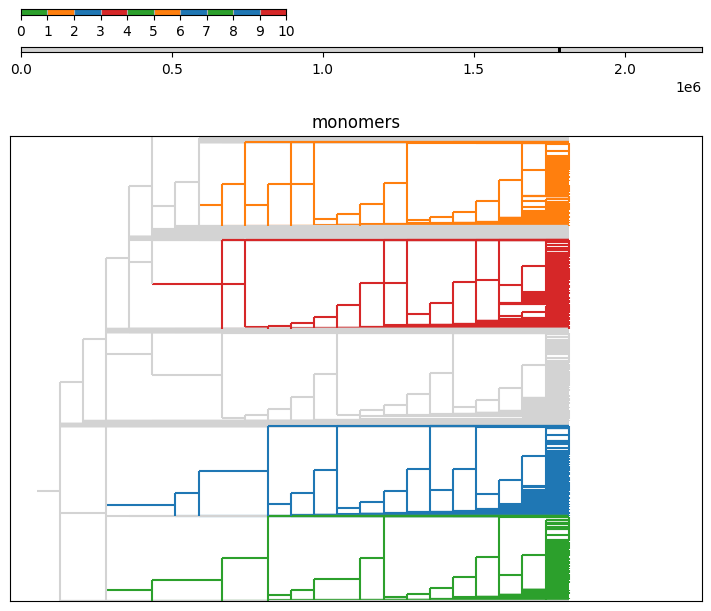

Subtree: [2, 2, 1, 1]
None


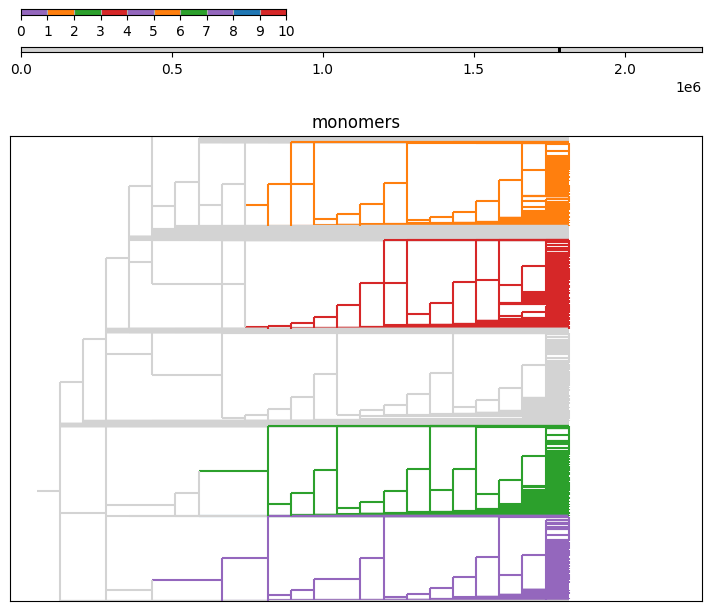

Subtree: [2, 3]
None


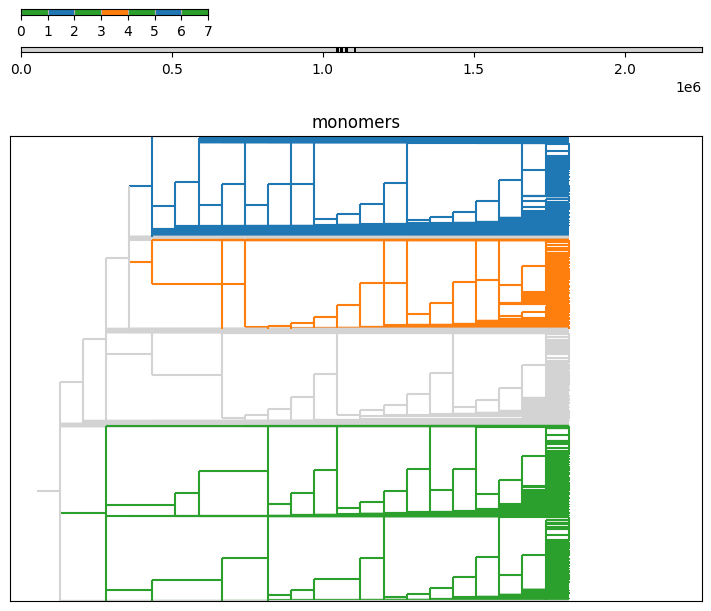

Subtree: [2, 3, 1]
None


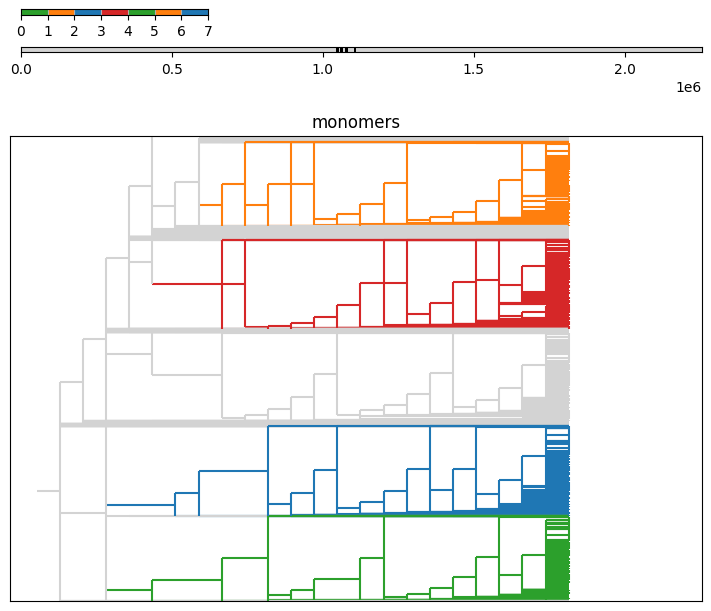

Subtree: [2, 4]
None


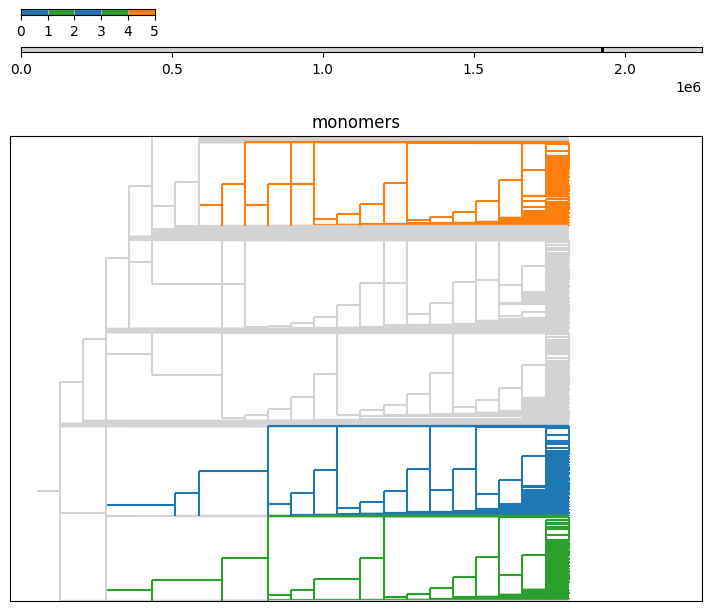

Subtree: [2, 5]
None


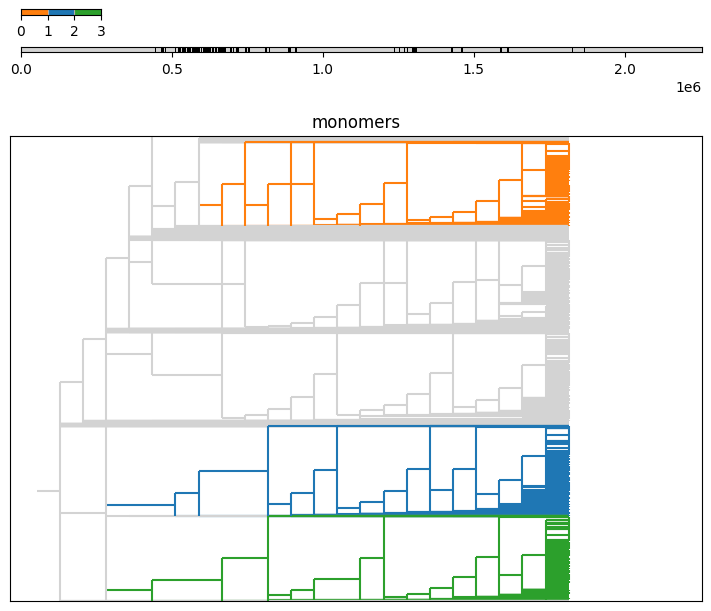

Subtree: [2, 6]
None


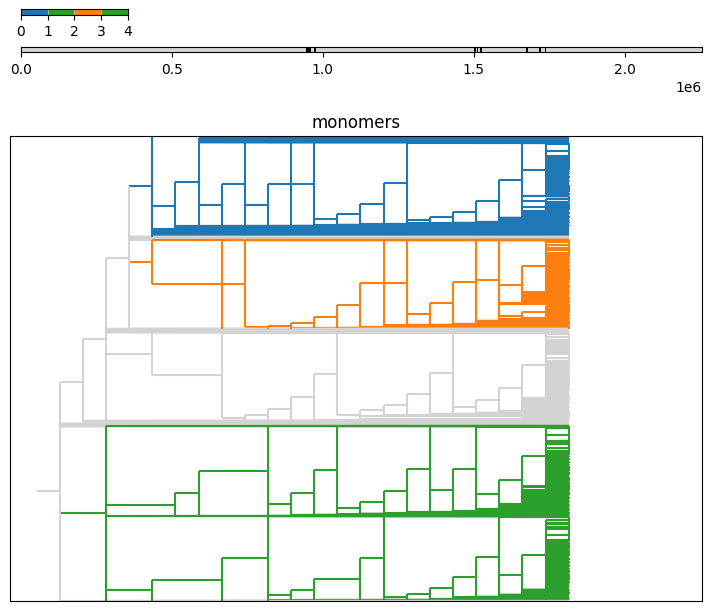

Subtree: [2, 6, 1]
None


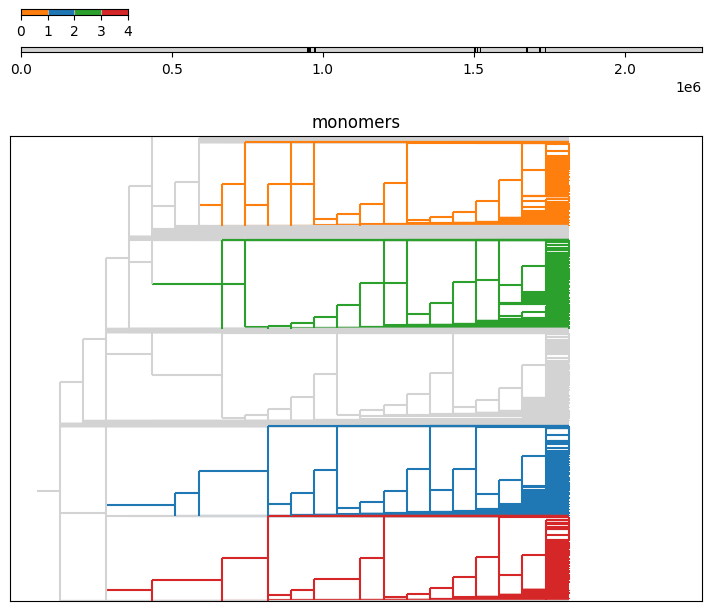

In [ ]:
show_hor_tree(hor_tree_root=hor_tree_root, reference_seq=references['chr4_hap2_hsa5:64806450-67061718'], tree=phylogeny)